## Importing packages

In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles
import numpy as np
from utils.notebook_helpers import *
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
warnings.simplefilter('ignore')

In [3]:
pd.set_option('display.max_columns', 10)
pd.set_option("display.precision", 5)

In [4]:
bundles.aaai2024()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.3, 2.039512162874653),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 9,
 'axes.labelsize': 9,
 'legend.fontsize': 7,
 'xtick.labelsize': 7,
 'ytick.labelsize': 7,
 'axes.titlesize': 9}

In [5]:
plt.rcParams.update(bundles.aaai2024())
# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 150})

In [6]:
root_path = '_models_trained/causal_nf'

### Running notes

To run for a new dataset, *copy* all the cells that are for a particular existing dataset, e.g., German, and paste them in the bottom of the notebook. 

*OR*

Make a copy of the notebook to have the results of a dataset in a separate notebook.

---

Then, when loading `data_df`, call `load\_csv\_file` with proper data name and the split. If you want to see for the entire data, use `all`.

Similarly, load the yaml by using the proper data name.

### Important note regarding distribution plots!
You need to use proper `plot\_params`. E.g., in German, we use `plot_params = {'rows': 1, 'cols': 3, 'figsize': (7, 1.7), 'plot_idx_legend': 1}`. Importantly, pass *proper* cols, it should be the same *number of treatments*!


## German credit

In [22]:
# choose: train, val, test, all
data_df = load_csv_file(root_path, 'german', 'all')
params = load_yaml_config(root_path, 'german')

In [23]:
treatment_col_idxs = range(params['dataset__num_sensitive'] + params['dataset__num_covariate'], 
                           params['dataset__num_sensitive'] + params['dataset__num_covariate'] + params['dataset__num_treatment'])

total_features = params['dataset__num_sensitive'] + params['dataset__num_covariate'] + params['dataset__num_treatment'] + 1

treatment_features = [c.split('_F')[0] for c in data_df.columns[treatment_col_idxs]]

print('Treatment features:', treatment_features)

gender_col_name = data_df.columns[0].split('_F')[0]
class_col_name = data_df.columns[total_features - 1].split('_F')[0]

Treatment features: ['duration', 'credit_amount', 'installment_commitment']


In [24]:
plot_params = {'rows': 1, 'cols': 3, 'figsize': (7, 1.7), 'plot_idx_legend': 1}
result_dict = dtd_itd_analysis(data_df, params, plot=False)

## Measures of utilities

ESI formulae  for german credit: $ESI_{german}= y \times \text{amount} \times \frac{\text{rate}}{100} \times \frac{\text{duration}}{12}$. 
Here, have a multiplication by 10% since we assume equal rates for everyone. 

For homecredit we use $ESI_{homecredit} =  \text{Annuity} \times 12  \times \text{duration} - \text{Loan amount} $

Refer to the main paper for more details on this. 


In [25]:
# LGD 
df_0 = data_df[data_df[f'{gender_col_name}_F'] == 0]
df_1 = data_df[data_df[f'{gender_col_name}_F'] == 1]

factual_female_lgd = np.mean((1 - df_0[f'{class_col_name}_F']) * df_0['credit_amount_F'])
factual_male_lgd = np.mean((1 - df_1[f'{class_col_name}_F']) * df_1['credit_amount_F'])
counterfactual_male_lgd = np.mean((1 - df_1[f'{class_col_name}_TTD']) * df_1['credit_amount_CF'])
print(f"<LGD> Factual female: {factual_female_lgd}, Factual male: {factual_male_lgd}, Treated male: {counterfactual_male_lgd}")

# ESI
factual_female_esi = np.mean((df_0[f'{class_col_name}_F']) * (df_0['credit_amount_F'] * (df_0['duration_F']/12) / 100)) * 10
factual_male_esi = np.mean((df_1[f'{class_col_name}_F']) * (df_1['credit_amount_F']  * (df_1['duration_F']/12) / 100)) * 10
counterfactual_male_esi = np.mean((df_1[f'{class_col_name}_TTD']) * (df_1['credit_amount_CF'] * (df_1['duration_CF']/12) / 100)) * 10
print(f"<ESI> Factual female: {factual_female_esi}, Factual male: {factual_male_esi}, Treated male: {counterfactual_male_esi}")


<LGD> Factual female: 1220.5129032258064, Factual male: 1163.8826086956522, Treated male: 940.0341430144928
<ESI> Factual female: 312.13282258064515, Factual male: 495.6460144927536, Treated male: 393.85995881427675


## Risks

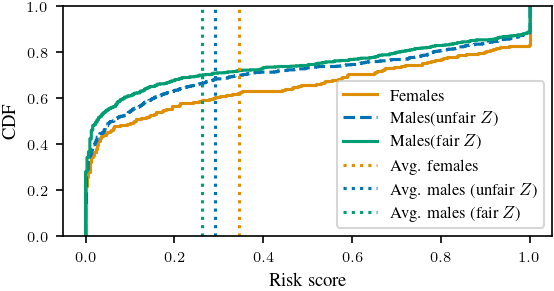

In [26]:
df_0 = data_df[data_df[f'{gender_col_name}_F'] == 0]
df_1 = data_df[data_df[f'{gender_col_name}_F'] == 1]

palette = sns.color_palette('colorblind')

f, axes = plt.subplots(1,1,figsize=(3.75,2), sharex=True, sharey=True)

sns.ecdfplot(x=df_0['risk_score_treat_female'], ax=axes, label='Females', color=palette[1])
sns.ecdfplot(x=df_1['risk_score_treat_male'], ax=axes, label='Males(unfair $Z$)', color=palette[0], linestyle='--')
sns.ecdfplot(x=df_1['risk_score_treat_female'], ax=axes, label='Males(fair $Z$)', color=palette[2])
axes.axvline(np.mean(df_0['risk_score_treat_female']), linestyle=':', color=palette[1], label='Avg. females')
axes.axvline(np.mean(df_1['risk_score_treat_male']), linestyle=':', color=palette[0], label='Avg. males (unfair $Z$)')
axes.axvline(np.mean(df_1['risk_score_treat_female']), linestyle=':', color=palette[2], label='Avg. males (fair $Z$)')
axes.set_ylabel('CDF')
axes.set_xlabel('Risk score')
axes.legend(ncols=1,fontsize=8)
plt.savefig('risk_cdf_german.pdf', dpi=100)

---------